### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


### 读取Mnist数据集
- 会自动进行下载

In [324]:
%matplotlib inline

In [325]:
from pathlib import Path
import requests
PATH_file =Path( r'D:\studydata\machine_bild_learn\AI\资料\缺陷检测章节资料\PyTorch基础\2-神经网络实战分类与回归任务\神经网络实战分类与回归任务\data\mnist\mnist.pkl.gz')


In [326]:
import pickle
import gzip

with gzip.open((PATH_file).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [327]:
import tensorflow as tf
print(f"Tensor Flow Version: {tf.__version__}")
from tensorflow import keras
from tensorflow.keras import layers,models

Tensor Flow Version: 2.13.0


784是mnist数据集每个样本的像素点个数

(50000, 784)
0


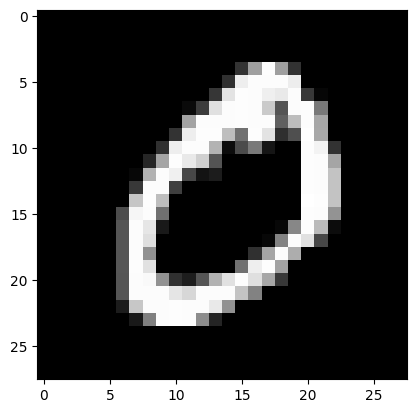

In [328]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[1].reshape((28, 28)), cmap="gray")
print(x_train.shape)
print(y_train[1])

<img src="./img/4.png" alt="FAO" width="790">

<img src="./img/5.png" alt="FAO" width="790">

注意数据需转换成tensor才能参与后续建模训练


In [329]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
#x_train, x_train.shape, y_train.min(), y_train.max()
#print(x_train, y_train)
print(n,c)
print(x_train.shape)
print(y_train.shape)
print(y_train.min(), y_train.max())

50000 784
torch.Size([50000, 784])
torch.Size([50000])
tensor(0) tensor(9)


### torch.nn.functional 很多层和函数在这里都会见到

torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些

In [330]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights) + bias

In [331]:
bs = 64
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]
print(xb.shape)
weights = torch.randn([784, 10], dtype = torch.float,  requires_grad = True) 
bs = 64
bias = torch.zeros(10, requires_grad=True)
print(bias)
print(loss_func(model(xb), yb))

torch.Size([64, 784])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
tensor(17.1585, grad_fn=<NllLossBackward0>)


### 创建一个model来更简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [332]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out  = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x
        

In [333]:
net = Mnist_NN()
print(net)


Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


可以打印我们定义好名字里的权重和偏置项

In [334]:
for name, parameter in net.named_parameters():
    print(name, parameter,parameter.size())

hidden1.weight Parameter containing:
tensor([[-0.0085,  0.0312,  0.0140,  ...,  0.0257, -0.0149, -0.0349],
        [ 0.0051, -0.0155, -0.0175,  ...,  0.0356,  0.0087,  0.0147],
        [ 0.0130,  0.0244, -0.0144,  ...,  0.0082,  0.0239, -0.0183],
        ...,
        [ 0.0026, -0.0208, -0.0256,  ...,  0.0290,  0.0035,  0.0221],
        [ 0.0086,  0.0185,  0.0098,  ...,  0.0335, -0.0189, -0.0190],
        [-0.0050,  0.0131, -0.0200,  ..., -0.0094,  0.0010,  0.0094]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([-2.1184e-02,  1.4606e-03, -1.3085e-02,  1.5034e-02, -1.4020e-02,
         1.8842e-02, -1.3378e-02,  1.2307e-02, -2.6112e-02,  3.0850e-02,
        -1.6591e-02, -2.1995e-02,  2.5079e-02, -5.1379e-03, -2.7634e-02,
         1.1312e-02,  1.3873e-04,  8.1840e-03, -9.1874e-03, -1.8534e-02,
         1.6100e-02,  5.7096e-03, -1.4701e-02, -2.0264e-02,  1.5518e-02,
        -1.7882e-03,  2.6316e-02,  2.1472e-02, -8.3282e-03,  2.4869e-02,
      

### 使用TensorDataset和DataLoader来简化

In [335]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [336]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [337]:
import numpy as np
#steps:训练次数(epoch)
#model:模型(Mnist_NN)
#loss_func:损失函数(F.cross_entropy)
#opt:优化器(optim.SGD)
#train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
#train_dl:训练集(train_ds = TensorDataset(x_train, y_train))
#valid_dl:验证集(valid_ds = TensorDataset(x_valid, y_valid))
train_losses = []  # List to store training losses
valid_losses = []  # List to store validation losses
def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss=loss_batch(model, loss_func, xb, yb, opt)
            tarinloss,trainnum = zip(*[loss])
            train_loss=np.sum(np.multiply(tarinloss, trainnum)) / np.sum(trainnum)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        valid_losses.append(val_loss)
        print('当前step:'+f'{step+1}/{steps}', f'Training Loss: {train_loss:.4f}','验证集损失：'+str(val_loss))


In [338]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [339]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

### 三行搞定！

In [340]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(25, model, loss_func, opt, train_dl, valid_dl)
#print(train_loss,val_loss)

当前step:1/25 Training Loss: 2.2767 验证集损失：2.274593022918701
当前step:2/25 Training Loss: 2.2247 验证集损失：2.2371059051513673
当前step:3/25 Training Loss: 2.1790 验证集损失：2.1787894664764402
当前step:4/25 Training Loss: 2.0622 验证集损失：2.082989835357666
当前step:5/25 Training Loss: 1.7755 验证集损失：1.9281261169433594
当前step:6/25 Training Loss: 1.5433 验证集损失：1.7068772550582885
当前step:7/25 Training Loss: 1.3916 验证集损失：1.450783151435852
当前step:8/25 Training Loss: 1.1610 验证集损失：1.2123912401199342
当前step:9/25 Training Loss: 0.8673 验证集损失：1.0216688814163208
当前step:10/25 Training Loss: 1.1555 验证集损失：0.8790760816574097
当前step:11/25 Training Loss: 0.9726 验证集损失：0.7725337973594666
当前step:12/25 Training Loss: 0.5681 验证集损失：0.6921296997070312
当前step:13/25 Training Loss: 0.5559 验证集损失：0.6293694160461426
当前step:14/25 Training Loss: 0.5857 验证集损失：0.5803983006477356
当前step:15/25 Training Loss: 0.4164 验证集损失：0.5414986032009125
当前step:16/25 Training Loss: 0.6310 验证集损失：0.5094116192340851
当前step:17/25 Training Loss: 0.2710 验证集损失：0.483538130

In [341]:
#train_losses

[2.2767348289489746,
 2.2247486114501953,
 2.1790177822113037,
 2.062224864959717,
 1.7754526138305664,
 1.5433343648910522,
 1.391571283340454,
 1.1609596014022827,
 0.8672518730163574,
 1.1555482149124146,
 0.9726318717002869,
 0.5681352019309998,
 0.5559350252151489,
 0.5857340693473816,
 0.4164499044418335,
 0.631029486656189,
 0.27104219794273376,
 0.48273521661758423,
 0.5662023425102234,
 0.5426141619682312,
 0.8018500804901123,
 0.19887034595012665,
 0.18664202094078064,
 0.29441335797309875,
 0.6546444892883301]

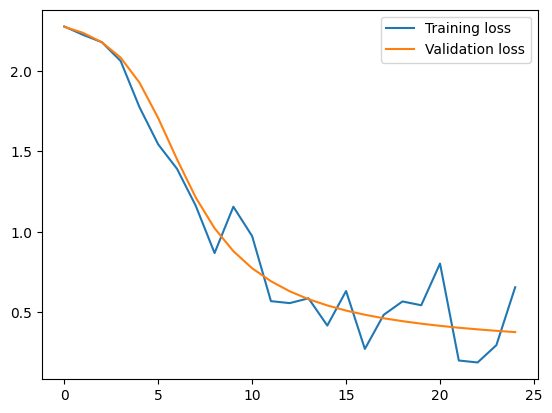

In [342]:


pyplot.plot(train_losses, label='Training loss')
pyplot.plot(valid_losses, label='Validation loss')
pyplot.legend()
pyplot.show()
